# XAI Assignment 1 - Implementing Layer-wise Relevance Propogation (LRP)

## Training
You can run the following codes to train a baseline model on MNIST.

### Import Libraries

In [1]:
import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from matplotlib import pyplot as plt

### Hyperparameters

In [2]:
batch_size = 32
num_epoch = 2
log_interval = 500

### Load the MNIST Dataset

In [3]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_set = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=transform)

/home/mjlee/anaconda3/envs/mj/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Define a Baseline Model

In [4]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

### Train/Test Functions

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Prepare Device/Dataloader/Model/Optimizer

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

model = Baseline()
model = model.to(device)
optimizer = optim.Adam(model.parameters())

### Train/Test Loop

In [7]:
for epoch in range(1, num_epoch + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)
torch.save(model.state_dict(), 'model.pth')

/home/mjlee/anaconda3/envs/mj/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309954
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.127898


KeyboardInterrupt: 

## Layer-wise Relevance Propogation (LRP)
You must implement LRP (ϵ-rule) below.  
1. Implement LRP (compute the input attribution given a model, an input image x, and a rule).
2. You may have to modify the forward function of the baseline.


In [11]:
def LRP(model, x, epsilon):
    logits = model.forward(x, epsilon)
    ###################################################
    # Implement LRP here.
    
    layers = [model.conv1, 
            nn.ReLU(),
            model.conv2,
            nn.ReLU(),
            nn.MaxPool2d(2),
            model.dropout1,
            nn.Flatten(),
            model.fc1,
            nn.ReLU(),
            model.dropout2,
            model.fc2,
         ]
    print(f'input shape: {x.shape}')
    
    L = len(layers)
    A = [x]+[None]*L
    for l in range(L): A[l+1] = layers[l].forward(A[l])
        
    R = [None]*L + [(A[L]*torch.tensor(y==np.arange(10)).unsqueeze(0).cuda())]
        
    attribution = None
    
    eps = epsilon
    for l in range(0,L)[::-1]:
        A[l] = (A[l].data).requires_grad_(True)
        
        if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

        if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
            z = layers[l].forward(A[l]) + eps # step 1
            s = (R[l+1]/z).data                                    # step 2
            (z*s).sum().backward(); c = A[l].grad                  # step 3
            R[l] = (A[l]*c).data                                   # step 4

        elif isinstance(layers[l],torch.nn.Linear):
            z = layers[l].forward(A[l])+layers[l].bias+ eps
            s = R[l+1]/z
            c = s.matmul(layers[l].weight)
            R[l] = A[l]*c

        elif isinstance(layers[l], torch.nn.Flatten):
            R[l] = R[l+1].reshape(A[l].shape)

        else:
            R[l] = R[l+1]
    
    attribution = R[0].squeeze().cpu().numpy()
    ###################################################
    return logits, attribution

In [12]:
class BaselineForLRP(nn.Module):
    def __init__(self):
        super(BaselineForLRP, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
            
    def forward(self, x, epsilon):
        ###################################################
        # Change this part.
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)        
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        ###################################################
        return output

### Load a Trained Model

In [15]:
model = BaselineForLRP()
model.load_state_dict(torch.load('model.pth'))
model.to(device)
model.eval()

BaselineForLRP(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Visualize the Input Attribution

input shape: torch.Size([1, 1, 28, 28])


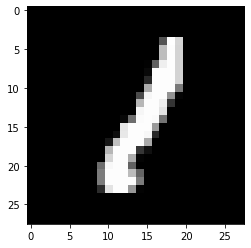

label: 1
predicted: 1
output probability: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
torch.Size([28, 28])


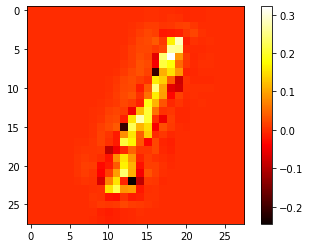

In [17]:
idx = np.random.randint(len(test_set))

x, y = test_set[idx]

logits, attribution = LRP(model, x.to(device).unsqueeze(0), epsilon=1e-1)

# print(attribution)
logits = logits[0]
prob = torch.softmax(logits, 0)
prediction = torch.argmax(logits)

plt.imshow(x[0], cmap='gray')
plt.show()

np.set_printoptions(suppress=True, precision=3)
print('label:', y)
print('predicted:', prediction.item())
print('output probability:', prob.detach().cpu().numpy())
print(x[0].shape)
if attribution is not None:
    plt.imshow(attribution, cmap='hot')
else:
    plt.imshow(x[0], cmap='hot')
plt.colorbar()
plt.show()